## Introduction

The UK constituencies are the key determinant of the general election outcome due to the “First Past the Post” System, which mainly leads to the Conservative or Labour parties winning majority of the constituency seats and forming a government. Thus, by analyzing numerous characteristics of these constituencies like past voting behaviour or demographic data such as population density, one can employ clustering algorithms to group them into clusters with similar features. There may be several reasons to do this. For example, clustering may help explain general trends or patterns, provide a broad view of differences between constituencies, or even based on the analysis, political parties may attempt to adapt their campaign efforts to the set of constituencies prone to switch their voting behaviour in their favour.

One example of this is an appealing [data science blog post by Ballard (2019)](https://www.cb91.io/projects/election) with its [associated GitHub repository](https://github.com/calbal91/project-understanding-elections) where the author: collects several types of constituency data from the UK parliament website; carries out feature engineering and scaling steps; implements a Hierarchical Agglomerative Clustering (HAC) algorithm to underline any anomalous voting behaviour from constituencies; and finally utilises the 2017 election data to predict the voting choices of each constituency in the 2019 general election. Although we can augment that analysis in several ways, our current project will dive deeper into investigating alternatives to HAC and search which clustering algorithms and metrics provide us with the best clusterings concerning the UK political datasets, which can be of benefit to political researchers and parties. Furthermore, we believe it is advantageous to provide an example analysis project that highlights the different degrees of freedom researchers have when performing clustering analysis and the effects those choices have on the results.

Therefore, we will explore alternatives with the following Clustering workflow:

1. **Feature Engineering and Selection**

    The first key ingredient of any clustering analysis is the data upon which it is based. In this section, we will discuss some of the variables involved in our analysis and explore the (possible) effects of including or excluding them.

2. **Dimensionality Reduction**

    In certain contexts, it is vital to conduct dimensionality reduction before attempting clustering, especially for distance-based algorithms like K Means. Here we explore two possible methods: PCA (linear) and UMAP (non-linear).

3. **Clustering Model**

    The main component of a clustering analysis is the model or algorithm selection. Besides HAC, we will consider K-means, Gaussian Mixture Modelling (GMM) and DBScan.

4. **Optimality Criteria/Metric**

    Depending on the algorithm chosen, we require particular metrics that can assist in selecting the optimal number of clusters where different criteria may lead to varying results. Here we will review metrics such as Distortion, Silhouette Score, Calinski-Harabasz, and the Davies-Bouldin index. In addition, some criteria are method-specific, like Dendrograms for HAC or the Bayesian Information Criterion (BIC) for GMM.

Once the hyperparameters have been optimized for each model, we will further inspect the generated segments, compare them across various algorithms and select the one that offers the most insightful and logical clusters.

All the code for this project can be found in [this GitHub repository](https://github.com/Areeb297/Warwick-Data-Science-Research-Project) which reuses some helpful code snippets from Ballard.


In [3]:
#For data manipulation
import numpy as np
import pandas as pd
import json
import math

# Hide all warnings
import warnings
warnings.filterwarnings("ignore")


#For data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.font_manager
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
sns.set()
from matplotlib.pylab import rcParams
import plotly.express as px


#For data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance


# Dimensionality Reduction
import umap
from sklearn.decomposition import PCA


#For clustering analysis
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN


#For evaluating clusters
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn import metrics

# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

#Allow ourselves to save things
import pickle

#For interactive tables
import itables
itables.init_notebook_mode(all_interactive=True) # to activate

<IPython.core.display.Javascript object>

In [4]:
df_con = pd.read_csv('data_with_targets.csv') # Our base dataset
df_con.set_index('ID', inplace=True)
df = pd.read_csv('data_with_targets.csv') # We will use this dataset for feature engineering and preprocessing purposes

In [5]:
#Define colours for the visuals
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

CB91_BlueD = '#016794'
CB91_GreenD = '#187970'
CB91_PinkD = '#B317B1'
CB91_PurpleD = '#4E1762'
CB91_VioletD = '#330E4C'
CB91_AmberD = '#985E09'

CB91_BlueL = '#ABE5FF'
CB91_GreenL = '#B5F1EB'
CB91_PinkL = '#FAD9FA'
CB91_PurpleL = '#D9A8EB'
CB91_VioletL = '#ECD4F5'
CB91_AmberL = '#F9D094'


#The following gradients will be used for heatmaps, etc
CB91_Grad_BP = ['#2CBDFE', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

CB91_Grad_BA = ['#2cbdfe', '#31bdf9', '#36bcf5', '#3bbcf0',
                '#41bcec', '#46bbe7', '#4bbbe3', '#50bbde',
                '#55bbd9', '#5abad5', '#60bad0', '#65bacc',
                '#6ab9c7', '#6fb9c3', '#74b9be', '#79b8ba',
                '#7eb8b5', '#84b8b0', '#89b7ac', '#8eb7a7',
                '#93b7a3', '#98b79e', '#9db69a', '#a3b695',
                '#a8b690', '#adb58c', '#b2b587', '#b7b583',
                '#bcb47e', '#c1b47a', '#c7b475', '#ccb371',
                '#d1b36c', '#d6b367', '#dbb363', '#e0b25e',
                '#e6b25a', '#ebb255', '#f0b151', '#f5b14c']

CB91_Grad_AP = ['#f5b14c', '#f3ae4f', '#f0aa52', '#eea755',
                '#eca458', '#eaa05c', '#e79d5f', '#e59962',
                '#e39665', '#e19368', '#de8f6b', '#dc8c6e',
                '#da8971', '#d88574', '#d58277', '#d37f7b',
                '#d17b7e', '#cf7881', '#cc7584', '#ca7187',
                '#c86e8a', '#c66a8d', '#c36790', '#c16493',
                '#bf6096', '#bd5d9a', '#ba5a9d', '#b856a0',
                '#b653a3', '#b450a6', '#b14ca9', '#af49ac',
                '#ad46af', '#ab42b2', '#a83fb5', '#a63bb9',
                '#a438bc', '#a235bf', '#9f31c2', '#9d2ec5']

CB91_Grad_GP = ['#47dbcd', '#4bd9ce', '#50d8cf', '#54d6d0',
                '#59d5d1', '#5dd3d2', '#61d2d3', '#66d0d4',
                '#6acfd5', '#6fcdd6', '#73ccd6', '#78cad7',
                '#7cc9d8', '#80c7d9', '#85c6da', '#89c4db',
                '#8ec3dc', '#92c1dd', '#96c0de', '#9bbedf',
                '#9fbde0', '#a4bbe1', '#a8bae2', '#acb8e3',
                '#b1b7e4', '#b5b5e5', '#bab4e6', '#beb2e7',
                '#c2b1e8', '#c7afe9', '#cbaee9', '#d0acea',
                '#d4abeb', '#d9a9ec', '#dda8ed', '#e1a6ee',
                '#e6a5ef', '#eaa3f0', '#efa2f1', '#f3a0f2']

CB91_Grad_GWP= ['#47dbcd','#4fdcce','#56ddd0','#5dded1',
                '#64dfd2','#6ae0d3','#70e1d5','#75e2d6',
                '#7be3d7','#80e4d8','#85e5da','#8ae6db',
                '#8fe7dc','#94e8dd','#98e9df','#9deae0',
                '#a1ebe1','#a6ece2','#aaede4','#afede5',
                '#b3eee6','#b7efe8','#bbf0e9','#c0f1ea',
                '#c4f2eb','#c8f3ed','#ccf4ee','#d0f5ef',
                '#d4f6f1','#d8f6f2','#dcf7f3','#e0f8f5',
                '#e4f9f6','#e8faf7','#ecfbf8','#f0fcfa',
                '#f3fcfb','#f7fdfc','#fbfefe','#ffffff',
                '#fdfafe','#fbf5fc','#f9f0fb','#f7eaf9',
                '#f4e5f8','#f2e0f7','#f0dbf5','#eed6f4',
                '#ecd1f2','#e9ccf1','#e7c7f0','#e5c1ee',
                '#e2bced','#e0b7eb','#deb2ea','#dbade8',
                '#d9a8e7','#d6a3e5','#d49ee4','#d199e2',
                '#cf94e1','#cc8fdf','#ca89de','#c784dc',
                '#c57fdb','#c27ad9','#bf75d8','#bd6fd6',
                '#ba6ad5','#b765d3','#b45fd2','#b25ad0',
                '#af54cf','#ac4ecd','#a949cb','#a642ca',
                '#a33cc8','#a035c7','#9d2ec5']

CB91_Grad_BWP= ['#2cbdfe','#31bffe','#37c0fe','#3cc2fe',
                '#42c4fe','#47c5fe','#4cc7fe','#52c9fe',
                '#57cbfe','#5dccfe','#62cefe','#68d0fe',
                '#6dd1fe','#72d3fe','#78d5fe','#7dd6fe',
                '#83d8fe','#88dafe','#8ddbfe','#93ddfe',
                '#98dfff','#9ee1ff','#a3e2ff','#a8e4ff',
                '#aee6ff','#b3e7ff','#b9e9ff','#beebff',
                '#c3ecff','#c9eeff','#cef0ff','#d4f1ff',
                '#d9f3ff','#dff5ff','#e4f7ff','#e9f8ff',
                '#effaff','#f4fcff','#fafdff','#ffffff',
                '#fdfafe','#fbf5fc','#f9f0fb','#f7eaf9',
                '#f4e5f8','#f2e0f7','#f0dbf5','#eed6f4',
                '#ecd1f2','#e9ccf1','#e7c7f0','#e5c1ee',
                '#e2bced','#e0b7eb','#deb2ea','#dbade8',
                '#d9a8e7','#d6a3e5','#d49ee4','#d199e2',
                '#cf94e1','#cc8fdf','#ca89de','#c784dc',
                '#c57fdb','#c27ad9','#bf75d8','#bd6fd6',
                '#ba6ad5','#b765d3','#b45fd2','#b25ad0',
                '#af54cf','#ac4ecd','#a949cb','#a642ca',
                '#a33cc8','#a035c7','#9d2ec5']

#Add party colors
con_blue = '#0A3B7C'
lab_red = '#E4003B'
lib_yel = '#FAA61A'
snp_yel = '#FFF481'
green_green = '#52DF00'
brex_blue = '#00E2ED'
ukip_pur = '#470A65'
plaid_green = '#006A56'

con_lab = '#992281'
con_lib = '#837859'
con_snp = '#85987f'
lab_lib = '#ef532b'
lab_snp = '#f27a5e'
lib_snp = '#fccf4d'


#A list that we'll use to cycle through colors in charts
color_list = [CB91_Blue, CB91_Green, CB91_Amber, CB91_Pink,
              CB91_Violet, CB91_BlueD, CB91_GreenD, CB91_Purple,
              CB91_AmberL, CB91_BlueL, CB91_GreenL, CB91_AmberD, 
              CB91_VioletD, CB91_PinkL, CB91_VioletL, CB91_PinkD]

In [6]:
def cluster_IDs(cluster, cluster_data, cluster_col='Cluster'):
    
    '''
    Takes a cluster label (1, 2, 3, etc.) and a cluster dataframe,
    and returns a list of constituency IDs that belong to the given cluster
    '''
    return list(cluster_data.loc[cluster_data['Cluster']==cluster].index)



def cluster_kpi(kpi, data, cluster_data, cluster_col='Cluster'):
    
    '''
    For a given set of cluster labels, and a given KPI, returns a
    dataframe with one row, for that given kpi
    '''
    
    #Find the unique cluster labels
    cluster_labels = sorted(list(cluster_data[cluster_col].unique()))
    
    #Declare an empty list to store the KPI data in
    kpi_values = []
    
    #Iterate through the labels
    for i in cluster_labels:
        #Work out which constituencies are in the cluster
        cluster_index = cluster_IDs(cluster = i,
                                    cluster_data = cluster_data,
                                    cluster_col = cluster_col)
        
        #Go to the data table, and find the mean for that kpi
        #for those constituencies. Append to the list
        mean = data.loc[cluster_index, kpi].mean()
        kpi_values.append(mean)
        
    #Create and return a dataframe as required
    return pd.DataFrame([kpi_values],
                        columns = cluster_labels,
                        index = [kpi])



def cluster_kpis(kpis, data, cluster_data, cluster_col='Cluster'):
    
    '''
    For a list of KPIs, return a dataframe showing mean
    values on a cluster by cluster basis
    
    '''
    
    #Declare an empty dataframe
    df_temp = pd.DataFrame()
    
    #For each kpi, find the average cluster means, and append to the dataframe
    for i in kpis:
        cluster_values = cluster_kpi(kpi=i,
                                     data=data,
                                     cluster_data=cluster_data,
                                     cluster_col=cluster_col)
        
        df_temp = pd.concat([df_temp, cluster_values])
        
    return df_temp
        
        

def heatmap_cluster_kpis(kpis, data,
                       cluster_data,
                       size=0.4,
                       cmap=CB91_Grad_BP,
                       cluster_col='Cluster'):
    
    '''
    Heatmap the table produced by the cluster_kpis function
    '''
    
    #Calculate the required table and transpose
    df_temp = cluster_kpis(kpis=kpis,
                           data=data,
                           cluster_data=cluster_data,
                           cluster_col=cluster_col).T
    
    #For each kpi, scale as required
    scaler = MinMaxScaler()
    scaler.fit(df_temp)
    df_scale = scaler.transform(df_temp)
    
    df_scale = pd.DataFrame(df_scale,
                            columns=df_temp.columns,
                            index=df_temp.index)
    
    height = size*len(df_scale.index)
    width = 1.1*size*len(df_scale.columns)
    
    plt.figure(figsize=(width,height))
    sns.heatmap(df_scale,cbar=True,cmap=cmap)
    plt.yticks(rotation='horizontal')


#Use seaborn to set all the default chart visual settings
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":16})

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [7]:
def gradient_mapper(kpi, grad, outliers=None, stretch=1, factor=1):
    
    '''
    Takes a list/series of numbers, outputs a list of hex colours,
    appropriate for heatmapping the initial data.
    
    Parameters:
    - col (list/series, etc.): The data to be transformed
    - grad (list hex codes): A list of colors that the data will be transformed to
    - outliers (top,bottom,both): Stretches the outliers, resulting in more gradient
                                  change amongst clustered values
    - stretch (int): The number of colors to duplicate if outliers variable used
    - factor (int): The scale of color duplication if outliers variable used
    
    '''
    #Work out how many colours we have in the given gradient
    colors = len(grad)
    half = colors // 2
    
    #Ensure that stretch is possible
    stretch = min(half//3, stretch)
    
    factors = [4*factor, 3*factor, 2*factor]
    
    if outliers != None:
        #Stretch gradient if required. Declare three lists:
        #Start is the stretch map for the bottom end
        if (outliers.lower() == 'bottom') or (outliers.lower() == 'both'):
            start = [factors[0]]*stretch + [factors[1]]*stretch + [factors[2]]*stretch
        else:
            start = []

        #End is the stretch map for the top end
        if (outliers.lower() == 'top') or (outliers.lower() == 'both'):
            end = [factors[2]]*stretch + [factors[1]]*stretch + [factors[0]]*stretch
        else:
            end = []

        #Middle is a list of 1s which will be non-transformed
        middle = [1 for i in range(colors - len(start) - len(end))]

        stretch_map = start + middle + end
        
    else:
        stretch_map = [1 for i in range(colors)]
        
    #Create tuples of the gradients, and the number of
    #times they should be repeated in the list
    zip_list = list(zip(grad,stretch_map))
    
    #Use this to create a list of lists
    #Each element will be a list of the same gradient
    #repeated the required number of times
    list_of_lists = [[i[0]]*i[1] for i in zip_list]
    
    #Melt this list of lists into a single list
    grad = sum(list_of_lists, [])
    
    #Re-define colors variable
    colors = len(grad)-1
    
    #Define the lowest and the highest points in the dataset
    kpi_min = kpi.min()
    kpi_max = kpi.max()
    
    #Transform the data to integers between zero and the length of the gradient list
    first_map = list(map(lambda x: int(round(colors*(x-kpi_min) /
                                             (kpi_max-kpi_min),0)), list(kpi)))
    
    #Map the integers onto the gradient list
    second_map = list(map(lambda x: grad[x], first_map))
    
    #Return this, as well as the new gradient
    return second_map, grad




f = open('constituencieshex.json')
datamap = json.load(f)
datamap = pd.DataFrame(datamap['hexes']).T
datamap = datamap[['n','q','r']]
datamap.columns=['Name','X','Y']

def kpi_map(kpi, width=6, colorbar=True,
            outliers=None, stretch=1, factor=1,
            exclude=[], title=None,
            colors=None, exc_color='#999999',
            grad=CB91_Grad_AP, data=df):
    
    '''
    Outputs a choropleth map, showing each constituency in the same size.
    
    Parameters:
    - kpi (list/series, etc.): The data to be transformed
    - width (float): The desired width of the figure
    - df (dataframe): The dataframe to get the data from
    - grad (list hex codes): A list of colors that the data will be transformed to
    - outliers (top,bottom,both): Stretches the outliers, resulting in more gradient
                                  change amongst clustered values
    - stretch (int): The number of colors to duplicate if outliers variable used
    - factor (int): The scale of color duplication if outliers variable used
    - exclude (list): A list of regions to exclude from the chart
    - colors (dataframe): A dataframe of hex-codes (index should be constituency codes)
    - title (string): The desired title of the chart
    
    '''    
    
    #Filter out different regions, depending on paramaters
    df_filtered = pd.concat([datamap, data[['Region',kpi]]], axis=1)
    
    #If we have colors to add, concatonate these in
    if isinstance(colors, pd.DataFrame):
        df_filtered = pd.concat([df_filtered, colors], axis=1)
        df_filtered.columns = ['Name', 'X', 'Y', 'Region', kpi, 'Colors']
    
    df_filtered = df_filtered.loc[~df_filtered['Region'].isin(exclude)]
    kpi_filtered = df_filtered[kpi]
    
    if isinstance(colors, pd.DataFrame) is False:
        #Use the gradient mapper function to return the colors for the plot
        gradient_map = gradient_mapper(kpi=kpi_filtered,
                                    grad=grad,
                                    outliers=outliers,
                                    stretch=stretch,
                                    factor=factor)
        colors_map = gradient_map[0]
    
    else:
        #Fill in nan colors with white
        df_filtered['Colors'].fillna(exc_color, inplace=True)
        
        #Return the column to be used as the colours list in the plot
        colors_map = list(df_filtered['Colors'])
    
    #Work out the aspect ratio of the filtered constituencies
    X_diff = np.max(df_filtered['X'])-np.min(df_filtered['X'])
    Y_diff = np.max(df_filtered['Y'])-np.min(df_filtered['Y'])
    
    #Declare the width and height of the plot
    height = width * (Y_diff/X_diff)
    size = 500*math.pi*((width/X_diff)**2)
    
    #Create the figure
    fig, ax = plt.subplots(figsize=(width,height))
    
    plt.xticks([])
    plt.yticks([])

    #Plot the scatter
    ax1 = fig.add_subplot(1,1,1)
    ax1.scatter(df_filtered['X'],
                df_filtered['Y'],
                s=size,
                marker='s',
                c=colors_map)
    
    #Remove axes
    sns.despine(left=True, bottom=True)
    ax1.set_title(title);
    
    #plot the colorbar
    if (colorbar == True) and isinstance(colors, pd.DataFrame) is False:        
        cmap = LinearSegmentedColormap.from_list(name= '',
                                                 colors=gradient_map[1])
        ax2 = fig.add_subplot(2,30,28)
        norm = mpl.colors_map.Normalize(vmin=df_filtered[kpi].min(),
                                    vmax=df_filtered[kpi].max())
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                       norm=norm, orientation='vertical')
    
        # remove the x and y ticks
        for ax in [ax1,ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
    
    else:
        ax1.set_xticks([])
        ax1.set_yticks([])

## Data pre-processing and Feature Engineering

To advance the work of Ballard, we use the same 2019 UK parliament constituency and the 2011 UK census data where the key variables include the wages per constituency, median house prices, unemployment changes in the past decade, house ownership type proportions, percentage of ethnicities, religious and age groups, broadband speeds and many more. One central  differentiation of our project, however, is that we chose to remove the regions variable to have no geographical influence on the clusters generated to detect more interesting clustering behaviour. Furthermore, we reduce the  categories of age, religion, and ethnicity to lower the dimensionality of our data. Moreover, to exclusively keep numerical variables for our clustering analysis, we remove the 2017 voting results categories per constituency where instead, we use directly the percentage of Conservative, Labour, Liberal, and SNP voters per constituency from the 2017 election. Including and excluding the SNP voter percentage will make up a major part of our clustering analysis later on. Additionally, we exclude the UKIP party vote due to the already existing EU referendum outcome present in the data. Lastly, we apply some log transformations to reduce skewness and “outlier influence” on the following variables: population density, area, number of businesses, wages, and house prices.

Here we can observe the full considered dataset interactively: 


In [8]:
# We first remove the Northern Ireland Region and Chorley seat (Speaker Seat) since these will cause outliers
df = df.loc[(df['Region'] != 'Northern Ireland')
           &(df['Constituency'] != 'Chorley')]

# Copy the data so you can use later if needed
data = df.copy()

df.set_index('ID', inplace=True)

# Remove constituency, type, and region column as we do not any geographic location data to affect our clustering
df = df.iloc[:, 4:]

# Reduce the ranges of the age columns
# Looking at all the age columns, it is best to combine some of them say above 60 category as the more older a person gets, 
# it maybe that he does not even vote or separating ages into such narrow categories does not seem to produce much benefit. 
# So our proposed categories would be (0-19) (how many kids/teenagers a household has, going uni etc), (20-29) 
# would involve uni,
# marriage, work life etc, (30-59) would include mainly parents, adulthood, maturity, richer category compared 
# to other categories, 60-80+ would represent old age categories.
# df['0-19%'] = df.iloc[:, 1] + df.iloc[:, 2]
df['0-9'] = df.iloc[:, 1] + df.iloc[:, 2]
df.rename(columns={'0-9': '0-19%'}, inplace=True)
df.drop(columns=['10-19'], inplace=True)

df['30-39'] = df['30-39'] + df['40-49'] + df['50-59']
df.rename(columns={'30-39': '30-59%'}, inplace=True)
df.rename(columns={'20-29': '20-29%'}, inplace=True)

df.drop(columns=['40-49', '50-59'], inplace=True)
df['60-69'] = df['60-69'] + df['70-79'] + df['80+']
df.rename(columns={'60-69': '60+%'}, inplace=True)
df.drop(columns=['70-79', '80+'], inplace=True)

# We will restrict born regions to 'Born UK', 'Born Asia', 'Born Other Europe', 'Born Rest of the World' which can 
# signficantly better focus target campaigns of different political parties as to target even more than 3 ethnicities
# does require lot of effort.

# With regards to religion, we can use the top 3-4 categories of religion according to wikipedia which would be Christianity, 
# Islam, No religion or atheism and Hinduisim. There are 7 categories in the current dataframe and targeting all these religions
# specifically would not be very effective. We will restrict to 4 categories specifically: Islam, Christianity, No religion and 
# other religion

# Born UK and being Christian is highly correlated or being white and christian or being south asian and muslim. 
# As our focus on predicting clusters rather than interpreting the parameters obtained, having such intercorrelation 
# issues should not be an issue.

# Lastly, concerning race colour, I believe the 4 mentioned (White, Black, Asian, Mixed) are sufficient to be used 
# for our clustering algorithms

# Country of Birth
df['%BornSouthAsia'] = df['%BornSouthAsia'] + df['%BornSEAsia'] + df['%BornEastAsia']
df.rename(columns={'%BornSouthAsia': '%Born_Asia'}, inplace=True)
df.drop(columns=['%BornSEAsia', '%BornEastAsia'], inplace=True)

df['%BornIreland'] = df['%BornIreland'] + df['%BornOtherEU'] + df['%BornOtherEurope']
df.rename(columns={'%BornIreland': '%Born_Other_Europe'}, inplace=True)
df.drop(columns=['%BornOtherEU', '%BornOtherEurope'], inplace=True)


df['%BornAfrica'] = df['%BornAfrica'] + df['%BornME'] + df['%BornNAmerica'] + df['%BornLatinAmerica'] + df['%BornAustralasia']
df.rename(columns={'%BornAfrica': '%Born_RestOf_theWorld'}, inplace=True)
df.drop(columns=['%BornME', '%BornNAmerica', '%BornLatinAmerica', '%BornAustralasia'], inplace=True)


# Religion
df['%Sikh'] = df['%Sikh'] + df['%Hindu'] + df['%Buddhist'] + df['%Jewish']
df.rename(columns={'%Sikh': '%Other_Religion'}, inplace=True)
df.drop(columns=['%Hindu', '%Jewish', '%Buddhist'], inplace=True)


# Obtain only the Great Britian dataset by droppping all columns which have NAs
# When we drop all columns with NAs, we keep rows with constituencies being from Scotland and Wales 
# as these constituencies cause the NAs mainly. 
# When we drop all rows with NAs, automatically these constituencies are removed

df_gb = df.dropna(axis=1)

# Apply log transformations to reduce skewness in the data for dimensionality reduction
df_gb[['AreaKM2', 'Pop_Density','Businesses', 'BusinessesPer1kCap','2019_Wage', 'HousePrice', 
       'HousePricePerWage']].apply(np.log1p, inplace=True)

# GB Dataset
X_gb = df_gb.iloc[:,:-3]
y17_gb = df_gb['Winner_17']
y17_st_gb = df_gb['seat_types_17']
y19_st_gb = df_gb['seat_types_yg'] # You Gov



# Add percentages of seats won by the conservative, labour, liberal, Scottish and Green party in every constituency
df_election = pd.read_csv('HoC-GE2017-constituency-results.csv', index_col='ons_id')
df_election.drop(columns=['ons_region_id', 'constituency_name', 'county_name', 'region_name',
       'country_name', 'constituency_type', 'declaration_time', 'result',
       'first_party', 'second_party', 'electorate'], inplace=True)

df_election.drop(columns=['invalid_votes', 'dup', 'sdlp', 'uup',
       'alliance', 'other', 'other_winner'], inplace=True)

df_election['con%'] = (df_election['con'] / df_election['valid_votes']) * 100
df_election['lab%'] = (df_election['lab'] / df_election['valid_votes']) * 100
df_election['ld%'] = (df_election['ld'] / df_election['valid_votes']) * 100
df_election['snp%'] = (df_election['snp'] / df_election['valid_votes']) * 100
df_election['green%'] = (df_election['green'] / df_election['valid_votes']) * 100
df_election.index.names = ['ID']

# Merge the two datasets together
# We will work with two datasets at the end - one with the % of snp votes included and the other without
# This is so we can analyze the clusters we get based on either including or excluding the column
X_gb_with_snp = pd.concat([X_gb, df_election[['con%','lab%','ld%','snp%']]], axis=1, join='inner')

X_gb_without_snp = pd.concat([X_gb, df_election[['con%','lab%','ld%']]], axis=1, join='inner')

In [9]:
itables.options.maxBytes = 0
itables.options.maxColumns = 60
itables.show(X_gb_with_snp)

Loading... (need help?)


## Dimensionality Reduction Methods

Progressing ahead to feature reduction, this is crucial due to the curse of dimensionality hindrance since clustering methods rely mainly on distance metrics to quantify the similarity between observations. Consequently, excessive dimensionality will result in every data point being seemingly equidistant to one another, i.e., overfitting the data [(Yiu, 2019a)](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e). Therefore, by exploiting methods like UMAP and PCA, one can be restricted to the pertinent variables whilst also getting rid of multicollinearity and existent noise from the dataset.

Regarding PCA, it is perhaps the most widely known method of dimensionality reduction. It transforms the data into a smaller orthogonal components that contain the primary underlying trends of the data [(Yiu, 2019b)](https://towardsdatascience.com/understanding-pca-fae3e243731d). Another prominent and state-of-the-art non-linear transformation used for data visualisation usually, is Uniform Manifold Approximation and Projection, i.e., UMAP, which computes and evaluates the similarity scores between highly dimensional data points using an exponential probability distribution [(Allaoui et al., 2020)](https://link.springer.com/chapter/10.1007/978-3-030-51935-3_34). It is scalable with outstanding run-time performance as it exploits the stochastic gradient descent method whilst preserving the approximate vicinities between similar data points, thus retaining most of the global/macro data structure. As a result, it can be used generally in any machine learning problem for dimensionality reduction ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426); [Spacagna, 2021](https://towardsdatascience.com/manifold-clustering-in-the-embedding-space-using-umap-and-gmm-dbab26a9efba)). Hence, using both linear PCA and manifold learning can enable us to explore any disparity in the clusters generated and to determine whether one method is superior over the other based on the clusters.


In [10]:
# With SNP Votes
scaler = StandardScaler()
X_gb_scaled_snp = scaler.fit_transform(X_gb_with_snp)

# Without SNP Votes
scaler = StandardScaler()
X_gb_scaled_without_snp = scaler.fit_transform(X_gb_without_snp)

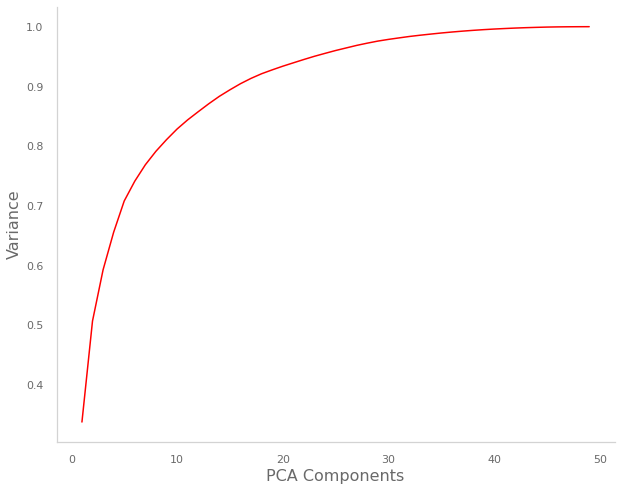

Loading... (need help?)


In [12]:
# log columns
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 50):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(X_gb_scaled_without_snp) # has 86 features
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')


plt.figure(figsize=(10,8))
sns.lineplot(x='n', y='var', data=pca_df, color='red')
plt.xlabel('PCA Components')
plt.ylabel('Variance')
plt.show()


pca_df.sort_values(by='var', ascending=False).head(40)

Concerning the number of selected components, we aim to retain 90% of the variance explained with PCA; this leads to 16 features. As for UMAP, we will pick the same number as PCA for a fair comparison of dimensionality. In addition, we add a random state to both these algorithms for reproducibility purposes.

![PCA variance plot](Blog_images/PCA_variance.png)

In [13]:
PCAmod = PCA(n_components=16, random_state=100)
PCAmod.fit(X_gb_scaled_snp)
PCA_df_gb = pd.DataFrame(PCAmod.transform(X_gb_scaled_snp))


PCAmod = PCA(n_components=16, random_state=100)
PCAmod.fit(X_gb_scaled_without_snp)
PCA_df_gb_without_snp = pd.DataFrame(PCAmod.transform(X_gb_scaled_without_snp))

# For fair comparison, we will select the number of components from UMAP (Non-Linear) as we did with PCA i.e., 16 components
umap_c = umap.UMAP(n_components=16, metric='euclidean' , init='random', random_state=0)
umap_df = umap_c.fit_transform(X_gb_scaled_snp)

umap_c = umap.UMAP(n_components=16, metric='euclidean' , init='random', random_state=0)
umap_df_without_snp = umap_c.fit_transform(X_gb_scaled_without_snp)

## A quick overview of considered Algorithms and Metrics

### K-Means

The popular K-Means algorithm starts by allocating k randomly placed centroids to the dataset and assigning points to the nearest centroid. Then it iteratively relocates the centroids to the mean of the assigned points and reassigns them based on the distance to the new centroids, leading to a reduction of the within-cluster sum of squares until convergence is reached. Some drawbacks of this method are that different initial starting points of centroids leads to different clustering results and the user is required to pre-specify the desired number of clusters
[(Garbade 2018)](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1).

### HAC

This commonly used technique exploits a distance metric to allocate clusters using a bottom-up clustering approach. It iteratively identifies pairs of points with minimal distance as clusters and successfully merges those pairs with the closest clusters [(Dobilas, 2021)](https://towardsdatascience.com/hac-hierarchical-agglomerative-clustering-is-it-better-than-k-means-4ff6f459e390). This leads to a hierarchy of clusters and subclusters within those, until each point is its own cluster. This method thus provides the added advantage of enabling us to visualize dendrograms, gain insight as to when and how the segmentation of a given cluster occurred, and select the clusterings that appear to be the most distinct.

### DBSCAN

The method of DBSCAN is *density based* meaning that it attempts to locate regions of high density by classifying data points as either core, reachable or outlier points. One advantage this algorithm brings is that it generates the number of clusters instead of requiring it as a hyperparameter input. However, an essential thing to point out is that UMAP does not preserve the density of the original data [(Taylor, 2019)](http://localhost:8889/notebooks/OneDrive/Documents/Super%20important%20documents/Warwick%20Data%20Science%20Research%20Project/Clustering%20Algorithms/Blog_Clustering_Template.ipynb). Hence, we expect DBSCAN to produce disparate results when working with PCA to when using UMAP. Additionally, not maintaining density is acceptable as we are searching for unique clusterings that can help us spot any specific or general trends. To create the best segments, the key hyperparameters we experiment with include; the minimum number of points for defining a cluster (min sample points); the in-sample distance for a point to be considered as part of a cluster (epsilon); and lastly, the algorithm to locate the nearest neighbours (ball_tree, kd_tree, brute, auto). DBSCAN effectively picks up high density, noise, and outlier patterns in the data however, it can be challenging to find the ideal cluster number [(Yildirim, 2020)](http://localhost:8889/notebooks/OneDrive/Documents/Super%20important%20documents/Warwick%20Data%20Science%20Research%20Project/Clustering%20Algorithms/Blog_Clustering_Template.ipynb).

### GMM

The last clustering method left to discuss, GMM, involves working with varying Gaussian distributions (a distribution-based model unlike K-Means or HAC which are distance based) that are used to assign probabilities (soft assignment/clustering) to each data point. These probabilities indicate which distributions would have likely generated a specific point. On the other hand, K-Means, HAC or DBSCAN are hard clustering methods which allocate a data point to only one cluster [(Foley, 2019)](https://towardsdatascience.com/gaussian-mixture-modelling-gmm-833c88587c7f#:~:text=At%20its%20simplest%2C%20GMM%20is,means%2C%20we%20have%20soft%20assignments). Hence, each cluster will consist of data points from a unique Gaussian distribution where the uncertainties of those points belonging to other clusters are also encapsulated. Thus, this method mostly avoids biases for specific clustering types and is valuable for non-linear and higher-dimensional data. Concerning the hyperparameters to be optimized, we select: the number of components or clusters similar to K-Means or HAC and the covariance matrix types of the clusters. The choices for the covariance matrices include full (clusters take arbitrary shape or position), tied (clusters have identical shapes), diagonal (contour shapes directed towards the coordinate axes with varying eccentricities of the ellipticals), and finally spherical (circular diagonal contours).

### Tuning Criteria

Regardless of which algorithm is employed, we require hyperparameter tuning for instance, finding the best cluster number in K-Means. We find numerous metrics available as tuning criteria. Starting with the Silhouette Score, it measures the inter-cluster separation where a value close to 1 indicates a greater distance between samples of one cluster to neighbouring cluster data points, which is ideal. Moving onto the Calinski-Harabasz Index or the Variance Ratio Criterion, it calculates the ratio between the dispersion of points within distinct clusters and the variability of observations in clusters. Thus, a higher index would be more valuable as the between-cluster variability ought to be low for superior segmentation, resulting in distant and compact clusters [(Baruah, 2020)](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad). Next we have the Davies Bouldin Index which computes the average of similarity scores between a cluster and its most identical cluster. The similarity score involves calculating the ratio of intra-cluster distances to inter-cluster distances where a low result is ideal, unlike the previous metrics. The reason is trivial, as having denser clusters far away from neighbouring clusters produces the best segmentation [(Zuccarelli, 2021)](https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6#:~:text=The%20Davies%2DBouldin%20Index%20is,lead%20to%20a%20better%20score). Lastly, concerning BIC, it locates the hyperparameters that result in the least number of parameters being used that still explain the data reasonably when running the GMM model. Thus, the higher the BIC score is, the more parameters need to be introduced to cluster the data. The ultimate aim would be to minimise this metric based on the Occam’s razor principle [(Klassen, 2020)](https://towardsdatascience.com/an-intuitive-explanation-of-the-bayesian-information-criterion-71a7a3d3a5c5). As GMM implements the expectation maximization (EM) algorithm and the maximum likelihood estimation framework, we can use the BIC score as an evaluation metric in this case.

In [14]:
# Define all the UK political parties and their colours we will use for later in our visualizations 

party_list = ['con safe','con lab marginal',
'lab safe','ld safe',
'con ld marginal','lab ld marginal',
'green safe', 'con snp marginal', 'snp safe', 'ld snp marginal']


party_colors = [con_blue, con_lab, lab_red, lib_yel,con_lib, lab_lib, 
                green_green, con_snp, snp_yel, lib_snp]



# Metric Visuals

def elbow_visuals(metr, model, data):
    if str(metr) == 'Distortion':
        visualizer = KElbowVisualizer(model, k=(2,18), timings= True)
        visualizer.fit(data)        # Fit data to visualizer
        visualizer.show()  
        
    elif str(metr) == 'Calinski':
        visualizer = KElbowVisualizer(model, k=(2,18), metric='calinski_harabasz', timings= True)
        visualizer.fit(data)        # Fit data to visualizer
        visualizer.show()  
        
    elif str(metr) == 'Silhouette':
        visualizer = KElbowVisualizer(model, k=(2,18), metric='silhouette', timings= True)
        visualizer.fit(data)        # Fit data to visualizer
        visualizer.show()  
        
# Dendogram for Heirarchical Clustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy


def dendro_hac(model, data):
    
    m = model.fit(data)
    Z = hierarchy.linkage(m.children_, 'ward')
    plt.figure(figsize=(20,10))
    plt.title("Dendrograms") 
    dn=hierarchy.dendrogram(Z)



def Davies_Bouldin_Viz(model, data):
    
    # Davies Bouldin Score
    # Davies Bouldin Index - need at least 2 points in each cluster
    # As DB Index falls, clustering improves
    # Davies Bouldin score for K means
    
    scores = []
    p = []
    centers = range(2, 20)
    
    if model == 'KMeans':
        
        for i in list(centers):
            kmeans = KMeans(n_clusters=i)
            m = kmeans.fit_predict(data)
            score = davies_bouldin_score(data, m)
            scores.append(score)
            p.append((i, score))
            
    if model == 'HAC':
        
        for i in list(centers):
            hac = AgglomerativeClustering(n_clusters=i)
            m = hac.fit_predict(data)
            score = davies_bouldin_score(data, m)
            scores.append(score)
            p.append((i, score))
            
#     display(round(pd.DataFrame(p)[1]), 4)
#     print(round(min(scores), 4))
    sns.lineplot(list(centers), scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('Davies Bouldin score');
    plt.title('Davies Bouldin score vs. K');
    
    df = pd.DataFrame(p)[round(pd.DataFrame(p)[1], 3) == round(min(scores), 3)]
    df.columns = ['# Clusters', 'Davies_Bouldin_Score']
    return df




    
# Heatmap function

def kpi_heatmap(kpi_data, data, snp=True):
    
    if snp == True:

        heatmap_cluster_kpis(kpis=kpi_data,data=X_gb_with_snp,cmap='coolwarm_r',size=0.7, cluster_data=data)
        plt.title('Heatmap of English Constituency Clusters by KPI\n\
        (0.0=Lowest Cluster For That KPI, 1.0=Highest Cluster For That KPI)\n')
        plt.ylabel('Cluster Number')
        
    if snp == False:
        
        heatmap_cluster_kpis(kpis=kpi_data,data=X_gb_without_snp ,cmap='coolwarm_r',size=0.7, cluster_data=data)
        plt.title('Heatmap of English Constituency Clusters by KPI\n\
        (0.0=Lowest Cluster For That KPI, 1.0=Highest Cluster For That KPI)\n')
        plt.ylabel('Cluster Number') 
        
    
    
def Map_cluster(data):
    kpi_map('Population',colors=data[['Colors']], data=df_con,
    exc_color='#ffffff',exclude=['Northern Ireland'], width=11)
    

def cluster_bar_visual(data, snp_included):

    gb_cluster_bar = (data/ data.sum()).T.sort_values(by='lab safe', ascending=True)

    gb_cluster_bar.plot.barh(stacked=True,
                  figsize=(12,5),
                  width=0.8,
                  color=party_colors)

    plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
    plt.xlim(0,1);
    
    if snp_included == True:

        plt.title('GB Constituency Clusters with %SNP Votes');
        
    else:
        plt.title('GB Constituency Clusters without %SNP Votes');
    plt.ylabel('Cluster Number')

    plt.legend(bbox_to_anchor=(0.85, -0.1),
                   ncol=4,frameon=False)
    
    
def clustering_metrics(model, data, clust=None): # yhat = model.fit(data)
    
    if clust == 'BIC':
        model.fit(data)
        model2 = model.predict(data)
        score_AGclustering_s = silhouette_score(data, model2, metric='euclidean')
        score_AGclustering_c = calinski_harabasz_score(data, model2)
        score_AGclustering_d = davies_bouldin_score(data, model2)
        
    else:
    
        yhat = model.fit(data)
        yhat_2 = model.fit_predict(data)

        # retrieve unique clusters
        # Calculate cluster validation metrics
        score_AGclustering_s = silhouette_score(data, yhat.labels_, metric='euclidean')
        score_AGclustering_c = calinski_harabasz_score(data, yhat.labels_)
        score_AGclustering_d = davies_bouldin_score(data, yhat_2)
    

    print('Silhouette Score: %.4f' % score_AGclustering_s)
    print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
    print('Davies Bouldin Score: %.4f' % score_AGclustering_d)  
    
    
def cluster_dataframes(preds, GMM=None, max_weights=None):
    
    gb_cluster_yg = pd.concat([y19_st_gb,
                       pd.DataFrame(preds[0],
                                    index=y17_st_gb.index,
                                    columns=['Cluster'])],
                       axis=1)
    
    
    gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                         index='seat_types_yg',
                                         columns='Cluster',

                                         aggfunc=len,
                                         fill_value=0)

    gb_cluster_yg_pivot = gb_cluster_yg_pivot.reindex(party_list)
    
    if GMM == True:
        
        gb_cluster_yg_2 = pd.concat([gb_cluster_yg, pd.DataFrame(max_weights,index=y17_st_gb.index,
                                    columns=['Weights'])], axis=1, join='inner')
    
        return gb_cluster_yg, gb_cluster_yg_pivot, gb_cluster_yg_2
    
    else:
        return gb_cluster_yg, gb_cluster_yg_pivot

In [15]:
# Clustering Algorithms

def K_Means(n_clusters, data):
    
    k_means = KMeans(n_clusters, random_state=0)
    k_means.fit(data)

    #Store the predicted labels
    km_preds_gb = []
    km_preds_gb.append(k_means.predict(data))
    
    clustering_metrics(k_means, data)
    
    return km_preds_gb
    


def HAC(n_clusters, data):
    
    #Instantiate and run a HAC algorithm
    HAC = AgglomerativeClustering(n_clusters)

    #Store the predicted labels
    hac_preds_gb = []
    hac_preds_gb.append(HAC.fit_predict(data))
    clustering_metrics(HAC, data)
    
    return hac_preds_gb

def DB_Clustering(ep, min_points, alg, data):
    
    db = DBSCAN(eps=float(ep), min_samples=float(min_points), algorithm=str(alg))
    #Store the predicted labels
    db_preds_gb = []
    preds = db.fit_predict(data)
    db_preds_gb.append(preds)
    clustering_metrics(db, data)
    
    # Fit the models
    clm46 = db.fit(data)
    # Print DBSCAN results
    print('*************** DBSCAN Clustering Model ***************')
    print("Cluster labels")
    print(np.unique(clm46.labels_))
    
    return db_preds_gb 


def Mean_Shift(b, data):
    
    ms = MeanShift(bandwidth=float(b)) 
    ms.fit(data)

    yhat = ms.predict(data)

    ms_preds_gb = []
    #Store the predicted labels
    ms_preds_gb.append(yhat)
    
    clustering_metrics(ms, data)
    
    return ms_preds_gb

def GMM(n_comp, covar, data):
    
    gmm = GaussianMixture(n_components=int(n_comp),covariance_type=str(covar), random_state = 100)
    gmm_preds_gb = []
    weights = []
    gmm.fit(data)
    preds = gmm.predict(data)
    weight = gmm.predict_proba(data)
    clustering_metrics(gmm, data, clust = 'BIC')
    gmm_preds_gb.append(preds)
    
    return gmm_preds_gb, weight

# Finalize the data function
# We will output this with our main function at the very end --> Section 4
def constituency_clusters(cluster_df, data, GMM=None):      

    if GMM == True:
        dframe = pd.concat([data, cluster_df], join='inner', axis=1)[['Constituency', 'Region', 'seat_types_yg', 'Colors', 'Cluster', 'Weights']]
    else:
        dframe = pd.concat([data, cluster_df], join='inner', axis=1)[['Constituency', 'Region', 'seat_types_yg', 'Colors', 'Cluster']]
    dframe = dframe.loc[:,~dframe.columns.duplicated()].reset_index()

    return dframe



def DBScan_func(dim_red, metric, data, snp_inc=True):

    score = []
    # Define ranges to explore
    eps_range=range(3,13)  
    minpts_range=range(3,11)
    if snp_inc == False:
        eps_range=range(3,6)  
    
    for k in eps_range:
        for j in minpts_range:
            for x in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            
                if str(dim_red) == 'PCA':
                    model = DBSCAN(eps=k, min_samples=j, algorithm=x)
                    clm = model.fit(data)
                    score_d = davies_bouldin_score(data, clm.labels_)
                    score_s = metrics.silhouette_score(data, clm.labels_, metric='euclidean')
                    score_h = metrics.calinski_harabasz_score(data, clm.labels_)
                    score.append((k, j, score_d, score_s, score_h, x))

                elif str(dim_red) == 'UMAP':
                    model = DBSCAN(eps=k/10, min_samples=j, algorithm=x)
                    clm = model.fit(data)
                    score_d = metrics.davies_bouldin_score(data, clm.labels_)
                    score_s = metrics.silhouette_score(data, clm.labels_, metric='euclidean')
                    score_h = metrics.calinski_harabasz_score(data, clm.labels_)
                    score.append((k/10, j, score_d, score_s, score_h, x))
                
    score_1 = pd.DataFrame(score)
    score_1.columns = ['Epsilon', 'Minimum_points', 'Davies_Bouldin_Score', 'Silhouette_Score', 'Calinski_Harabasz', 'Algorithm']
    
    if str(metric) == 'Davies Bouldin':
        score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
        
    elif str(metric) == 'Silhouette':
        score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()] 
        
    elif str(metric) == 'Calinski':
        score_2 = score_1[score_1.Calinski_Harabasz == score_1.Calinski_Harabasz.max()]
    
    return score_2.head(2)


def Gaussian_MM_metrics(dim_red, metric, data):
    
        
    score = []
    n_components = range(2, 20)
    covariance_type = ['spherical', 'tied', 'diag', 'full']
    
    for cov in covariance_type:
        for n_comp in n_components:
            gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state=101, reg_covar=1e-04)
            gmm.fit(data)
            model2 = gmm.predict(data)
            Calin  = calinski_harabasz_score(data, model2)
            Silh   = silhouette_score(data, model2) 
            Davies = davies_bouldin_score(data, model2)
            score.append((cov,n_comp, gmm.bic(data), Calin, Silh, Davies))
            
            
    score_1 = pd.DataFrame(score)
    score_1.columns = ['Covariance_Type', 'N_Components', 'BIC_Score', 'Calinski_Harabasz_Score', \
                       'Silhouette_Score', 'Davies_Bouldin_Score']
    
        
    if str(metric) == 'BIC':
        score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]
        
    elif str(metric) == 'Davies Bouldin':
        score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
        
    elif str(metric) == 'Silhouette':
        score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]      
        
    elif str(metric) == 'Calinski':
        score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
        
    return score_2.head(2)


def Mean_Shift_metrics(dim_red, metric, data):
    
    if str(dim_red) == 'PCA':
        bandwidths = range(2, 11)
    elif str(dim_red) == 'UMAP':
        bandwidths = np.round(np.linspace(0.2, 1.2, 11), 2)
            
    score = []

    for b in bandwidths:
        ms = MeanShift(bandwidth=b)
        model = ms.fit(data)
        model_2 = model.predict(data)
        score_c = calinski_harabasz_score(data, model_2)
        score_d = davies_bouldin_score(data, model_2)
        score_s = silhouette_score(data, model_2, metric='euclidean')
        
        score.append((b, score_c, score_d, score_s))
        
    score_1 = pd.DataFrame(score)
    score_1.columns = ['Bandwidth', 'Calinski_Harabasz_Score', 'Davies_Bouldin_Score', 'Silhouette_Score']
    
    if str(metric) == 'Davies Bouldin':
        score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
        
    elif str(metric) == 'Silhouette':
        score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]      
        
    elif str(metric) == 'Calinski':
        score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
        
    else:
        print('Try again!')
        
    return score_2.head(2)

In [16]:
def WDSS_clustering(data, dim_reduction, clustering_method, metric_visuals=False, map_plot=False, cluster_bar=False,
                   metric=None, heatmap=False, dendrogram=False, snp_included=True):
    
    # Dimensionality Reduction 
    
    if dim_reduction == 'PCA':
        if snp_included == False:
            data_main = PCA_df_gb_without_snp
        else:
            data_main = PCA_df_gb
            
    elif dim_reduction == 'UMAP':
        if snp_included == False:
            data_main = umap_df_without_snp
        else:
            data_main = umap_df
            
 # Clustering Algorithms
 # K-Means:   
    
    if clustering_method == 'KMeans':
        model = KMeans(random_state=0)

        if metric_visuals == True:
            metr = input("Please input the metric of your choice from ['Distortion', 'Silhouette', 'Calinski', 'Davies Bouldin']: ")
            if metr == 'Davies Bouldin':
                display(Davies_Bouldin_Viz(clustering_method, data_main))
            else:
                elbow_visuals(metr, model, data_main)
        n_clust = int(input("Enter number of clusters: "))
        preds_gb = K_Means(n_clust, data_main)
            
            
     # HAC: 
    elif clustering_method == 'HAC':
        model = AgglomerativeClustering()
        
        if metric_visuals == True:
            metr = input("Please input from the visuals of your choice ['Distortion', 'Silhouette', 'Calinski', 'Davies Bouldin']: ")
            if metr == 'Davies Bouldin':
                display(Davies_Bouldin_Viz(clustering_method, data_main))
            else:
                elbow_visuals(metr, model, data_main)
                    
        if dendrogram == True:
            dendro_hac(model, data_main)
                     
        n_clust = int(input("Enter number of clusters: "))
        preds_gb = HAC(n_clust, data_main)
            
            
     # DB Scan:
    elif clustering_method == 'DBScan':  

        if metric_visuals == True:
            metr = input("Please input the metric of your choice from ['Davies Bouldin', 'Silhouette', 'Calinski']: ")
            display(DBScan_func(dim_reduction, metr, data_main, snp_inc=snp_included))

        if dim_reduction == 'UMAP':
            ep = input("Enter epsilon value from 0.3 or above: ")
        else:
            ep = input("Enter epsilon value from 3 or above: ")
            
        mns = input("Enter minimum samples value from 3 or above: ")
        algo = input("Enter algorithm type from the list: [‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’]: ")
        preds_gb = DB_Clustering(ep, mns, algo, data_main)
        
    # Mean Shift
            
    elif clustering_method == 'MS':

        if metric_visuals == True:
            metr = input("Please input the metric of your choice from ['Davies Bouldin', 'Silhouette', 'Calinski']: ")
            display(Mean_Shift_metrics(dim_reduction, metr, data_main))
                
        b = input("Enter bandwidth for Mean Shift: ")
        preds_gb = Mean_Shift(b, data_main)
            
            
     # GMM:
            
    elif clustering_method == 'GMM':

        if metric_visuals == True:
            metr = input("Please input the metric of your choice from ['BIC', 'Davies Bouldin', 'Silhouette', 'Calinski']: ")
            display(Gaussian_MM_metrics(dim_reduction, metr, data_main))
                
        n_compon = input("Enter number of components/clusters for GMM: ")
        covar = input("Enter the covariance type for GMM: ")
        preds_gb, weights = GMM(n_compon, str(covar), data_main)
    
        max_weights = []
        for i in weights:
            max_weights.append(i.max().round(6))
    
    if clustering_method == 'GMM':
        gb_cluster_yg, gb_cluster_yg_pivot, gb_cluster_yg_2 = cluster_dataframes(preds_gb, GMM=True, max_weights=max_weights)
        
    else:   
        gb_cluster_yg, gb_cluster_yg_pivot = cluster_dataframes(preds_gb)
    
    if len(np.unique(gb_cluster_yg['Cluster'])) >= 15:
        print("Too many clusters to show - reduce clusters from the current {} clusters".format(len(np.unique(gb_cluster_yg['Cluster']))))
        return gb_cluster_yg
    
    else:

        gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(lambda x: color_list[x])
        if cluster_bar == True:

            cluster_bar_visual(gb_cluster_yg_pivot, snp_included)

        if map_plot == True:
            Map_cluster(gb_cluster_yg)

            
        if clustering_method == 'GMM':
            gb_cluster_yg_2['Colors'] = gb_cluster_yg['Cluster'].map(lambda x: color_list[x])
            df = constituency_clusters(gb_cluster_yg_2, data, GMM=True)
            
        else:
            df = constituency_clusters(gb_cluster_yg, data)


        #Define a standard list of KPIs to look at

        if heatmap == True:
            if snp_included == True:

                kpis_gb = ['Pop_Density','2019_Wage', 'HousePricePerWage', '%HousePriceGrowth','%OwnOutright','%OwnWithMort',
                      '%PrivateRent','%SocialHousing','%Unemployment', 'UnemploymentChange',
                      '%Heavy Industry & Manufacturing', '%Wholesale & Retail',
                      '%FS & ICT', '%White', '%Muslim', '%BornUK','%Level4+', '%LeaveVote', 'con%', 'snp%', 'lab%']

                kpi_heatmap(kpis_gb, gb_cluster_yg)
                
            elif snp_included == False:
                kpis_gb = ['Pop_Density','2019_Wage', 'HousePricePerWage', '%HousePriceGrowth','%OwnOutright','%OwnWithMort',
                '%PrivateRent','%SocialHousing','%Unemployment', 'UnemploymentChange',
                '%Heavy Industry & Manufacturing', '%Wholesale & Retail',
                '%FS & ICT', '%White', '%Muslim', '%BornUK','%Level4+', '%LeaveVote', 'con%', 'ld%', 'lab%']

                kpi_heatmap(kpis_gb, gb_cluster_yg, snp=False)
        

        return df

## Model Results

Collectively, we could fit 60 models by combining all the metrics and algorithms where depending on the various decisions we could compare results obtained just altering the algorithm, or the choice of dimensionality reduction. To facilitate this exploration, we developed a function in Python which allows us to easily fit all of the choices just through changing the corresponding arguments: 


Please input from the visuals of your choice ['Distortion', 'Silhouette', 'Calinski', 'Davies Bouldin']:  Distortion


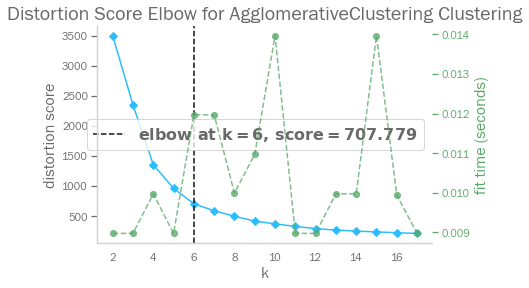

Enter number of clusters:  6


Silhouette Score: 0.4650
Calinski Harabasz Score: 833.8581
Davies Bouldin Score: 0.6868


Loading... (need help?)


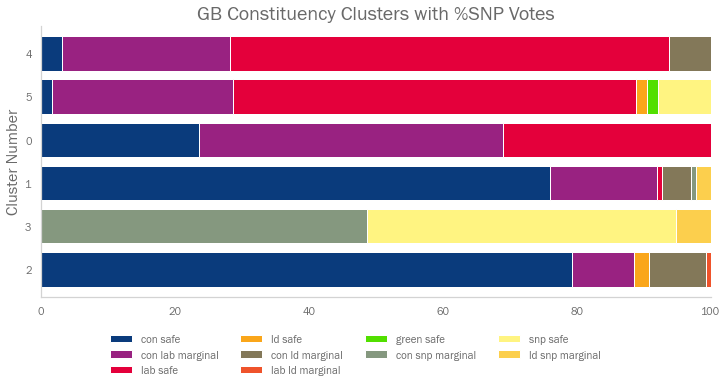

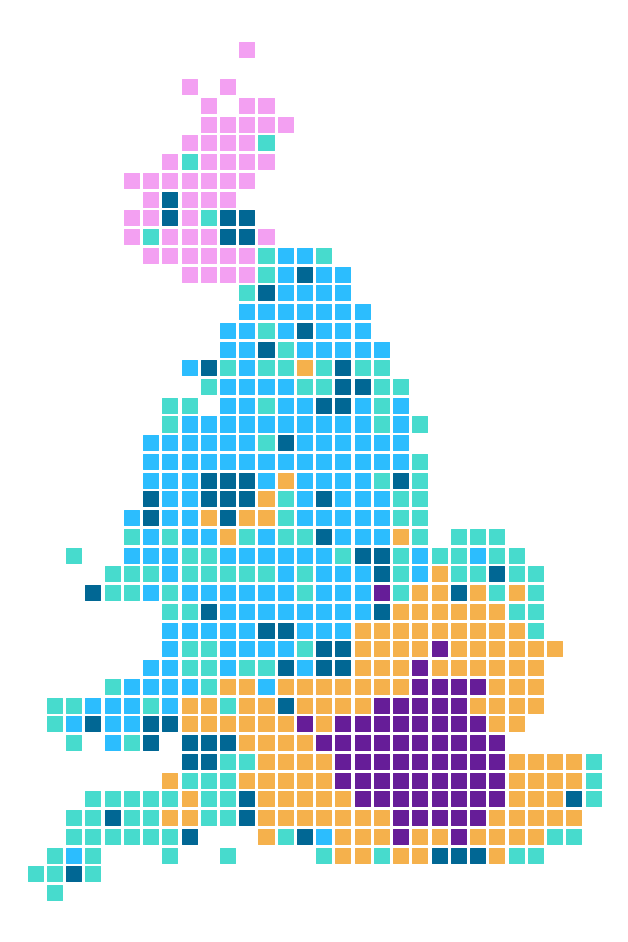

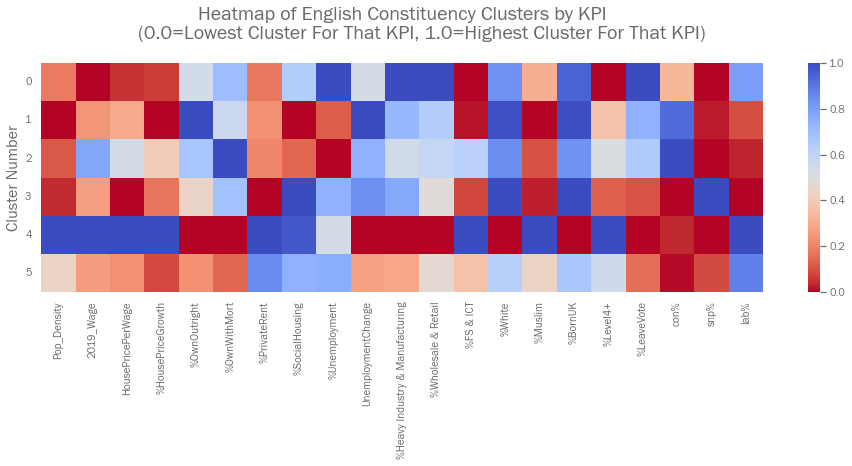

In [148]:
## Clustering Methods: HAC, KMeans, DBScan, GMM, MS
WDSS_clustering(data=df_con, dim_reduction='UMAP', clustering_method='HAC', map_plot=True, metric_visuals=True,
                    cluster_bar=True, heatmap=True, dendrogram=False, snp_included=True)

We also present an interactive table to see the recommended number of clusters for each model permutation: 

In [17]:
itables.init_notebook_mode(all_interactive=True)  # Activate

result = pd.read_excel("Clustering_results_2.xlsx").drop(columns=['Further Information','Model ID']).dropna()

itables.show(result, lengthMenu = [16, 30, 60])

<IPython.core.display.Javascript object>

Loading... (need help?)


We should point out that different operating systems may lead to slight variations in the recommended cluster number. Hence, for reproducibility purposes, we ran the code in Google Colab. 

We have visualized all the 60 possible results using R to spot general trends and augment our understandability of all model outcomes:

- Majority of the models, except for a few permutations with DBSCAN, show one particular cluster being mainly composed of London constituencies. 
- UMAP datasets tend to suggest a higher number of clusters than PCA.
- UMAP leans toward assigning the London region to its own cluster, whereas PCA connects other big city constituencies to the London cluster. 

![](Blog_images/All_Maps.png)

Before we proceed to investigate the different algorithms' results in more detail for political campaigns and insight, we assume a suitable cluster number would lie in the range of 4 – 10 approximately to effectively analyse and target anomalously behaving constituencies present in each cluster. With this in mind, we can now start searching for the best clustering solutions.


#### K-Means


Firstly, looking at K Means with PCA, both the Calinski and Silhouette metrics lead to selecting 2 clusters as the optimal clustering. One cluster consists of mainly London constituencies alongside a few other city constituencies towards the North and West directions like Bradford or Birmingham or even in Scotland. The second cluster comprises the rest of the constituencies. We get this result irrespective of whether we include the % of SNP votes or not. We can see an example of this clustering with PCA in the first panel of the following figure:


![](Blog_images/KMeans_Examples.png)


UMAP models generally assign Scotland (apart from some constituencies in Edinburgh or Glasgow) to its own cluster. This result occurs with or without incorporating the "Scottish identifying variable," the % of SNP votes. On the contrary, PCA models do not usually detect Scotland as its own cluster. An example of this behaviour was shown in the previous figure. Additionally, this time, the Calinski and Silhouette metrics produce slightly different clusterings with UMAP when we include or exclude the % of SNP voters. Perchance, the reason is UMAP detects non-linearities and subtleties better than PCA.

The Distortion and Davies Bouldin result in a higher and more appropriate number of clusters than the Calinski and Silhouette Indexes. Thus, these are the metrics to choose when working with this algorithm.


#### HAC 

Progressing ahead to HAC, this technique outputs similar results to K-Means under PCA, except that the K-Means clusterings appear to be more compact with a higher number of clusters. Additionally, the SNP voter feature makes a difference for some city constituencies in Scotland. For example, they stop being part of the London cluster when we include the % of SNP votes, the metric being the Silhouette or Calinski Index. Apart from that, there were no significant differences between the PCA HAC and K-Means permutations. 

On the other hand, UMAP HAC offers more diverse clusterings. In fact, we obtained one of the highest cluster numbers compared with all the 60 models with HAC when the model sequence is UMAP without SNP votes, with the metric or criteria being the Calinski score. Furthermore, HAC tends to narrow better the distinction between the inner London constituencies and their surrounding clusters than K-Means. Hence, when working with UMAP, one would pick HAC over K-Means due to the more logical and superior segmentation obtained. Finally, even when the recommended clusters are 12, HAC outputs structured and reasonable clusters based on the demographics of the UK constituencies.  

As mentioned before, one attractive feature of HAC is its hierarchical nature. Even if any metric like Silhouette recommends a specific cluster number, one can still inspect the relationship between the recommended cluster number combinations by visualizing how they merge on a dendrogram. For instance, in the following figure, we see an animation of how HAC aggregates clusters when using the PCA with the SNP voters dataset:

<a>
    <center> 
        <img src = "Blog_images/pca_snp_true.gif">
        <br>
        <img src = "Blog_images/Dendogram_PCA_SNP_true_reduced.png">
    </center>
</a>

If instead, we pick the UMAP without the %SNP votes dataset, the results divert to the following:
<a>
    <center> 
        <img src = "Blog_images/umap_snp_false.gif">
        <br>
        <img src = "Blog_images/Dendogram_UMAP_SNP_False_reduced.png">
    </center>
</a>

The distortion metric appears to be the most stable metric as we get the same 6 or 7 recommended segments.  

#### DBSCAN

For DBSCAN, we obtain the most unique but the least valuable clusterings, both with PCA and UMAP. We notice the results primarily being a London versus non-London divide concerning PCA. The London cluster tends to compose more city constituencies of Scotland and the rest of the UK compared with K-Means or HAC. One of the most surprising clusterings we notice is with the Davies Bouldin or Silhouette metric using PCA, where including the % SNP vote variable outputs two clusters. One cluster is identified as the "Cities of London and Westminster" constituency,  and all the other constituencies belong to the second cluster. This result shows how much of an outlier this central London constituency is. Alternatively, when more than 2 clusters are recommended, like when we use the Davies Bouldin without SNP model, the London region breaks down into several clusters, each possessing a few constituencies. Another variation is with the Calinski metric. Here we obtain three clusters that we could generally identify as London and a few big cities; most of Scotland; and the rest of the UK. 

Focusing on UMAP, DBSCAN seems to perform better with the Calinski metric when we include the SNP votes. Another distinctive clustering generated is the Scotland vs. Non-Scotland division when using the SNP votes, which could perhaps come from DBSCAN detecting the high density of SNP votes from the majority of the Scotland regions. Below are the most peculiar choropleth maps we stumbled across when working with DBSCAN.

![](Blog_images/DBScan_Examples.png)


#### GMM

Our final method, GMM, yields similar outcomes to HAC with PCA apart from the BIC metric. All the other metrics produce two clusterings, one involving London constituencies and a few constituencies in Birmingham, Manchester, Bradford, or Warley. The other cluster comprises the rest of the UK. These clustering maps could potentially be practical when searching for constituencies with similar characteristics to London. With the BIC metric, it performs well as we obtain 5 clusters with trivial variation irrespective of the inclusion or exclusion of the SNP voting percentage. Overall, the GMM method appears ineffective when working with PCA. 

Focusing on UMAP, the Calinski metric outputs several clusters (11-12) regardless of the SNP variable. However, GMM visibly picks up the Scotland cluster just like DBScan. Unlike other algorithms, all metrics work exceptionally well with GMM and UMAP, yielding the recommended cluster number in an ideal range of 5-8. Additionally, BIC is consistent with 7 clusters irrespective of inclusion of the % SNP votes. 

Since GMM is a form of *soft clustering*, we gain access to the probabilities or weights of each constituency belonging to a given cluster. Therefore, we can visually inspect our selected models' confidence in their cluster assignments. For example, we include a plot of the most uncertain model, i.e., which yields the highest number of low probability cluster assignments. As a result, we notice only four or five constituencies with a relatively low probability for their assigned cluster, while the rest are highly certain. However, the same permutation under UMAP has much higher confidence in its assignments, as shown in the figure below. This result is crucial as we can be confident that a clear separation of clusters occurs.

![](Blog_images/GMM_Probabilities.png)



## Discussion

Our results show that UMAP generally tends to output a less simplistic, more diverse clustering solution with all the clustering algorithms. Furthermore, UMAP is most effective with GMM and HAC, whereas PCA works well only with a few model permutations like K-Means with Davies Bouldin or Distortion. The distortion metric outputs similar clusterings in terms of the diversity and number of clusters regardless of PCA or UMAP. With PCA, the distortion metric does yield a more central and smaller London cluster relative to UMAP. However, when using other metrics, PCA primarily selects the aforementioned London versus Non-London clustering in contrast to UMAP, which identifies that clustering in addition to the Scotland and non-Scotland divide and other segments. As a result, it generates clusters having more geographic structure despite us having removed the regions variable from Ballard's dataset. Hence, UMAP happens to be a superior choice for political targeting when implementing clustering based on votes as it picks up both the London and Scotland separation. 

Moreover, among the considered algorithms, we saw that DBSCAN underperforms relative to K-Means, HAC, and GMM. Thus, for further inspection of the relationships between the obtained clusterings from these last 3 methods we take advantage of a Sankey diagram. This Sankey plot demonstrates how the usual two clusterings found with PCA evolve and transform into smaller clusters when switching the dimensionality reduction to UMAP. Even though the cluster number contrasts slightly between models, large *streams* or *flows* exist, signalling that many constituencies are always grouped together in the same cluster irrespective of the chosen algorithm. This allows us to approximately label and identify common clusters across models. For example, what we labelled as cluster A across models consists mostly of a single stream, and we identify it in the choropleth figure as being made up of the London constituencies. Similarly, clusters labelled as C can be associated with Scotland. If we see the clusters from the UMAP + GMM model, we also notice how the streams labeled B, D, E, or F are mostly preserved throughout the various algorithms, even if they get absorbed into bigger clusters. 

![](Blog_images/Sankey_Comparison.png)

Overall, we think that the HAC + UMAP + SNP model provides compeling results. It has a nice balance between the number of clusters with the general trends picked up by most models, such as the London, Scotland, or big cities patterns. We also see that it gives similar results to those of Ballard. We can then analyse each cluster's traits further in more detail under this particular model with the following interactive plot and heatmap. 


In [25]:
# Plotly interactive kpi map (made by myself)

def interactive_kpi_map(datamap, output_data):

    datamap_2 = pd.concat([output_data.set_index('ID'), datamap[['X', 'Y']]], axis=1, join='inner')
    fig = px.scatter(datamap_2, x='X', y='Y', width=700, height=1000, 
                     color='Cluster_Name', 
                     color_discrete_map={
                        "A": "#A92E5E",
                        "B": "#48BFE3",
                        "C": "#F5DB4B",
                        "D": "#FCAD12",
                        "E": "#000004",
                        "F": "#3A0963"},
                     custom_data=['Constituency', 'Region', 'Cluster_Name', 'seat_types_yg'], title='UK Constituency Map for UMAP + HAC + with %SNP')

    fig.update_traces(marker=dict(size=13.5,
    line=dict(width=0), symbol='square'),
    selector=dict(mode='markers'))



    fig.update_layout(showlegend=False, plot_bgcolor='rgba(0,0,0,0)')
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_xaxes(visible=False, showticklabels=False)



    fig.update_traces(
        hovertemplate="<br>".join([
        "Constituency: %{customdata[0]}",
        "Region: %{customdata[1]}",
        "Cluster: %{customdata[2]}",
        "YouGov Seat: %{customdata[3]}"
        ])
    )


    #fig.update_traces(marker=dict(color=datamap_2['Colors']))
        
    fig.show()

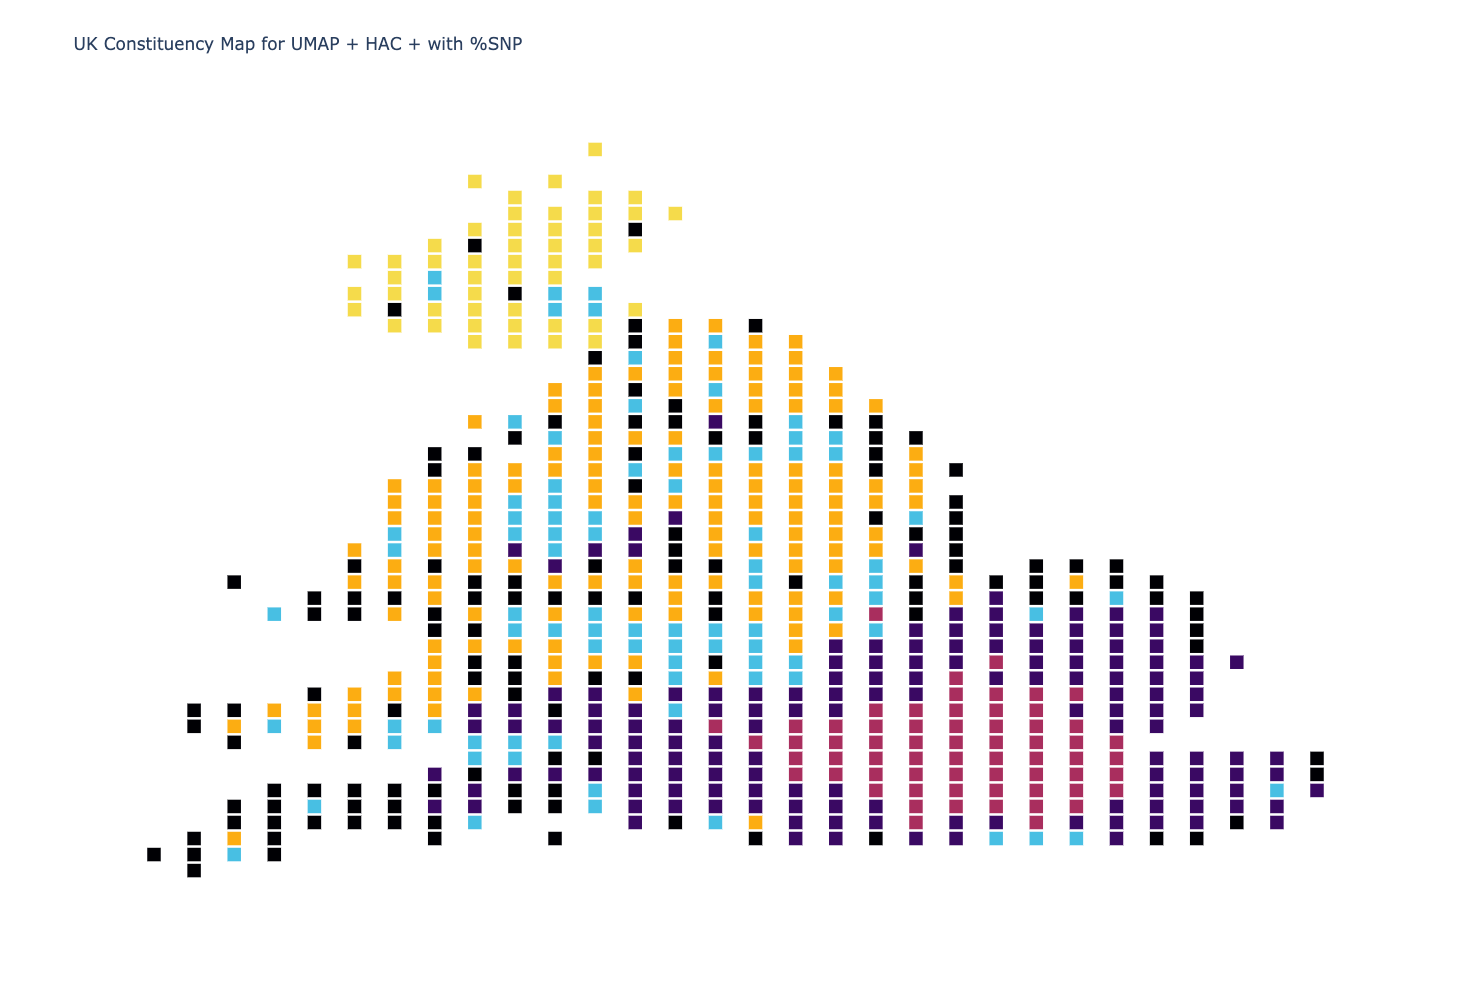

In [26]:
data_final_model = pd.read_csv('final_model.csv')
interactive_kpi_map(datamap = datamap, output_data = data_final_model)

The heatmap shows the normalized average value of the variables for each cluster across its constituencies. Hence a blue (orange) tile represents a cluster tending to have higher (lower) values than the rest of the clusters in the given variable. 

![](Blog_images/Final_Heatmap.png)

Exploring the characteristics of these clusters further, we can quickly notice that cluster A comprises London with few other city constituencies. This cluster includes substantial levels of Level 4+ educated individuals whose predominant support is for the Labour party and voted opposingly to Brexit, as seen on the heatmap. Furthermore, we spot that the algorithms classify C as mainly Scotland, and hence, we observe the high % SNP votes in this cluster. Moreover, F, for instance, consists of constituencies located right outside the London region, where these are highly conservative and primarily white. We see these two patterns further accentuated in cluster E. However the locations of the constituencies in this cluster do not follow any single geographical pattern.

One final cluster to investigate further would be B which mainly consists of the Midlands and main cities like Edinburgh, Nottingham, Birmingham, Leeds, Newcastle. This cluster has high unemployment rates, low wages, house prices, and high broadband speeds where it generally prefers Labour, somewhat analogous to A. Thus, by analyzing the general voting pattern per cluster, political parties can target those regions that voted anomalously relative to the majority of the constituencies in a given cluster. For instance, the constituencies in Cluster A are either Labour safe seats or Conservative Labour marginal seats. We got this information from the 2019 Multilevel regression and Poststratification (MRP) YouGov Poll results included in Ballard's dataset. So, as an example, Labour could perhaps target those marginal seats as the characteristics of those constituencies are similar to Labour safe constituencies. Similar is the case with cluster B, where since most of the constituencies support Labour, the Labour party could target the SNP safe seats of Glasgow and Edinburgh. In fact, considering the 2019 election results, using the same reasoning, the Conservative party was able to exploit some sociodemographic factors in cluster D to win seats across the so-called *Red Wall* region, like the Workington seat in Cumbria. 

## Future Work

For further research, one could experiment with other features. For instance, including the percentage of votes from other parties may prove helpful when identifying similar behaviour of constituencies compared to limiting our exploration only to the Conservative, Labour, Liberal Democrat, and SNP votes. Furthermore, the demographic and constituency statistical data that we worked with is outdated as we acquired it from the 2011 UK Census and the 2019 UK Parliament webpage. When writing this blog, the 2021 census data was not yet available. Thus, we deemed it best to go with the same data as Ballard to allow a comparison of results. However, it would be interesting to update it whenever the new census data is released. Moreover, since we worked with the 2019 MRP poll, we could use the [2021 MRP poll results](https://yougov.co.uk/topics/politics/articles-reports/2021/10/04/new-yougov-mrp-model-shows-conservatives-losing-32) to look at the voting behaviour trends of constituencies in each cluster. We could also use the actual 2019 election results instead of the 2017 election to detect any changes to our current results. Lastly, we can consider different dimensionality reduction techniques, particularly non-linear ones like t-SNE, as UMAP provided more informative results than PCA.
